### Bài 1: Xây dựng mô hình Transformer Encoder gồm 3 lớp theo mô tả trong nghiên cứu [Attention is all you need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). Huấn luyện mô hình này cho bài toán phân loại domain câu bình luận trên bộ dữ liệu [UIT-ViOCD](https://drive.google.com/drive/folders/1Lu9axyLkw7dMx80uLRgvCnZsmNzhJWAa?usp=sharing).

# 1. Đọc dữ liệu

In [3]:
import os
import torch

base_dir = './'

processed_dir = os.path.join(
    base_dir,
    "dataset",
    "UIT-Vi-OCD",
    "processed"
)

print(processed_dir)

./dataset\UIT-Vi-OCD\processed


In [4]:
train_data = torch.load(os.path.join(processed_dir, "train.pt"))
dev_data   = torch.load(os.path.join(processed_dir, "dev.pt"))
test_data  = torch.load(os.path.join(processed_dir, "test.pt"))

print(train_data.keys())
# dict_keys(['input_ids', 'attention_mask', 'labels'])

dict_keys(['input_ids', 'attention_mask', 'labels'])


idx = 0

print("Input IDs (sample):")
print(train_data["input_ids"][idx])

print("\nAttention mask (sample):")
print(train_data["attention_mask"][idx])

print("\nLabel (sample):")
print(train_data["labels"][idx])

# Cần có tokenizer để giải mã các input IDs về dạng token
# print("\nTokens:")
# print(xlm_tokenizer.convert_ids_to_tokens(
#     xlm_train_encodings["input_ids"][idx]
# ))

In [5]:
# Chuẩn bị biến cấu hình cho model

NUM_CLASSES = len(torch.unique(train_data["labels"]))
MAX_LEN = train_data["input_ids"].shape[1]

print("NUM_CLASSES:", NUM_CLASSES)
print("MAX_LEN:", MAX_LEN)

NUM_CLASSES: 4
MAX_LEN: 128


# 2. Chuẩn bị dữ liệu cho huấn luyện mô hình

Đưa dữ liệu đã encode => batch => sẵn sàng feed vào Transformer Encoder

## 2.1 Định nghĩa DomainDataset

Ở bước này ta không xử lý text nữa, Dataset chỉ đóng vai trò:

- lấy input_ids

- lấy attention_mask

- lấy labels

- trả về từng sample

In [6]:
from torch.utils.data import Dataset

class DomainDataset(Dataset):
    def __init__(self, data):
        self.input_ids = data["input_ids"]
        self.attention_mask = data["attention_mask"]
        self.labels = data["labels"]

    def __len__(self):
        return self.labels.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

## 2.2 Tạo dataset

In [7]:
train_dataset = DomainDataset(train_data)
dev_dataset   = DomainDataset(dev_data)
test_dataset  = DomainDataset(test_data)

print(len(train_dataset), len(dev_dataset), len(test_dataset))

4387 548 549


## 2.3. Tạo DataLoader (batch data)

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

dev_loader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## 2.4. Sanity check một batch từ DataLoader

In [9]:
batch = next(iter(train_loader))

print(batch.keys())
print("input_ids:", batch["input_ids"].shape)
print("attention_mask:", batch["attention_mask"].shape)
print("labels:", batch["labels"].shape)

# dict_keys(['input_ids', 'attention_mask', 'labels'])
# input_ids: torch.Size([32, 128])
# attention_mask: torch.Size([32, 128])
# labels: torch.Size([32])

dict_keys(['input_ids', 'attention_mask', 'labels'])
input_ids: torch.Size([32, 128])
attention_mask: torch.Size([32, 128])
labels: torch.Size([32])


# 3. Positional Encoding (Sin–Cos theo Attention Is All You Need)

Self-attention không có khái niệm thứ tự.
Do đó, Transformer cần một cơ chế để mã hóa vị trí của token trong chuỗi trước khi đưa vào các lớp Encoder.

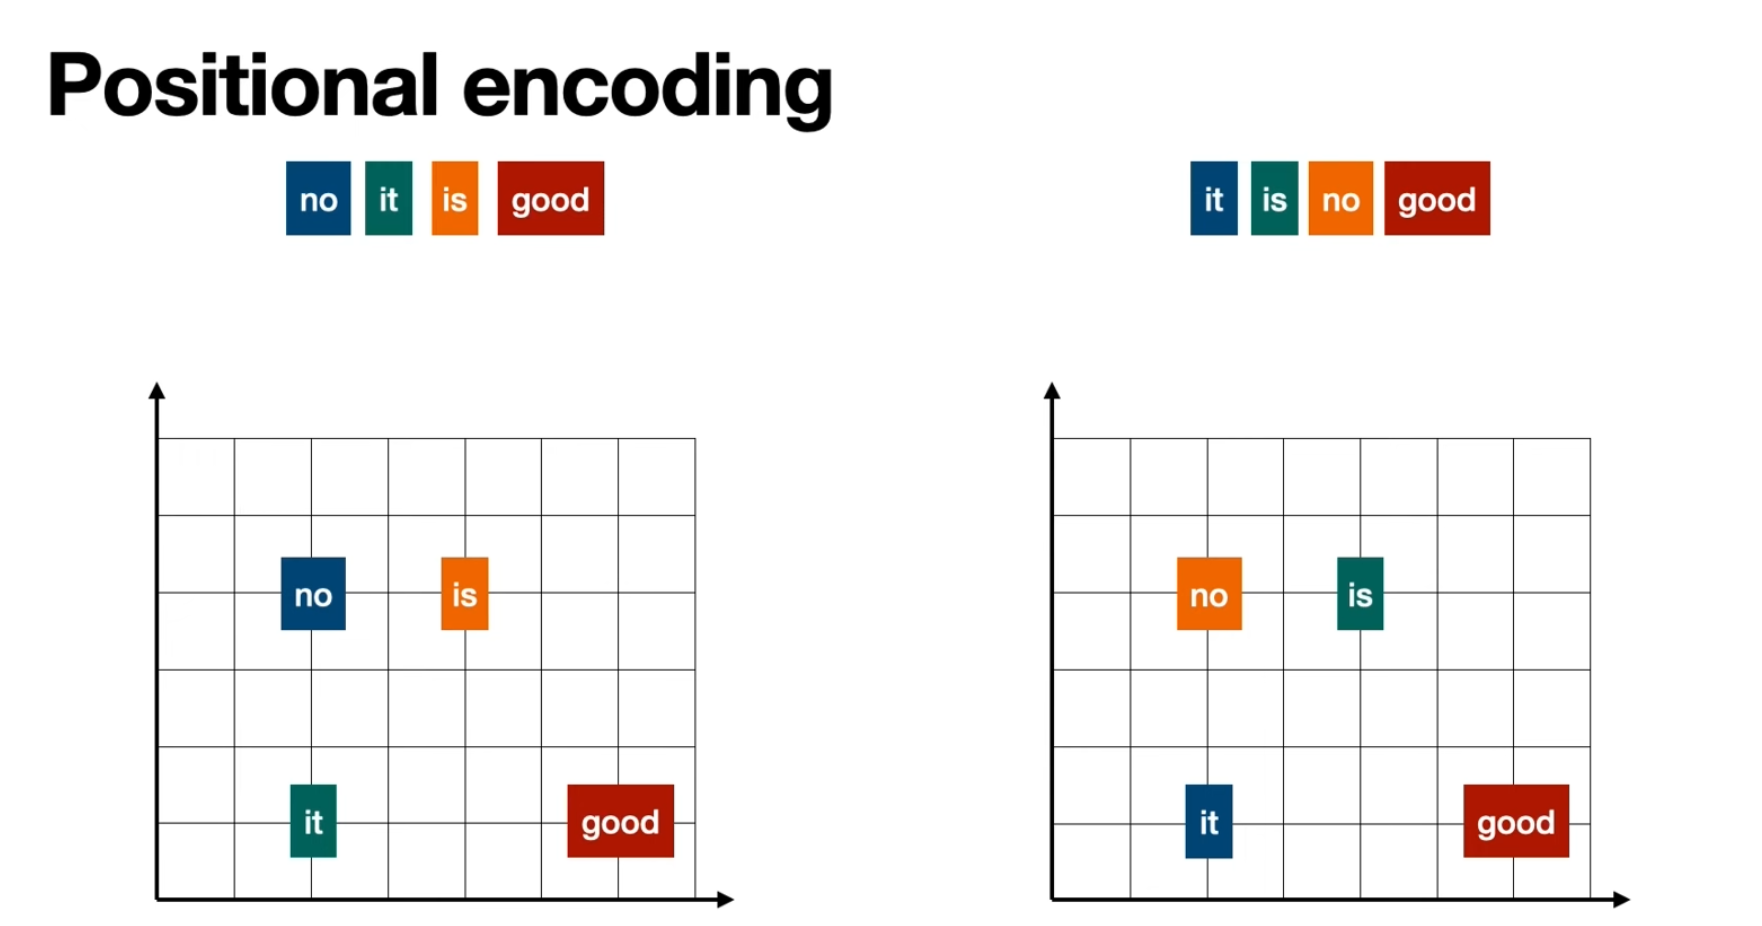

Ảnh trích từ video: https://www.youtube.com/watch?v=IHu3QehUmrQ

Có thể thấy là dù 2 câu có ý nghĩa khác nhau hoàn toàn, nhưng embedding hoạt động trên word-level nên hiện khi chưa có positional encoding thì 2 câu đang được hiểu y như nhau. Hình trên minh họa mỗi từ có embedding_dim = 2 (thực tế nhiều hơn, nhưng đang để minh họa) thì dù các từ có ý định biểu thị ngữ nghĩa khác lại có cúng không gian embedding vì nó đều là 1 từ.

Mục tiêu là làm sao cho embedidng của từ vừa mang nghĩa của từ đó vừa mang ý nghĩa của thứ tự.

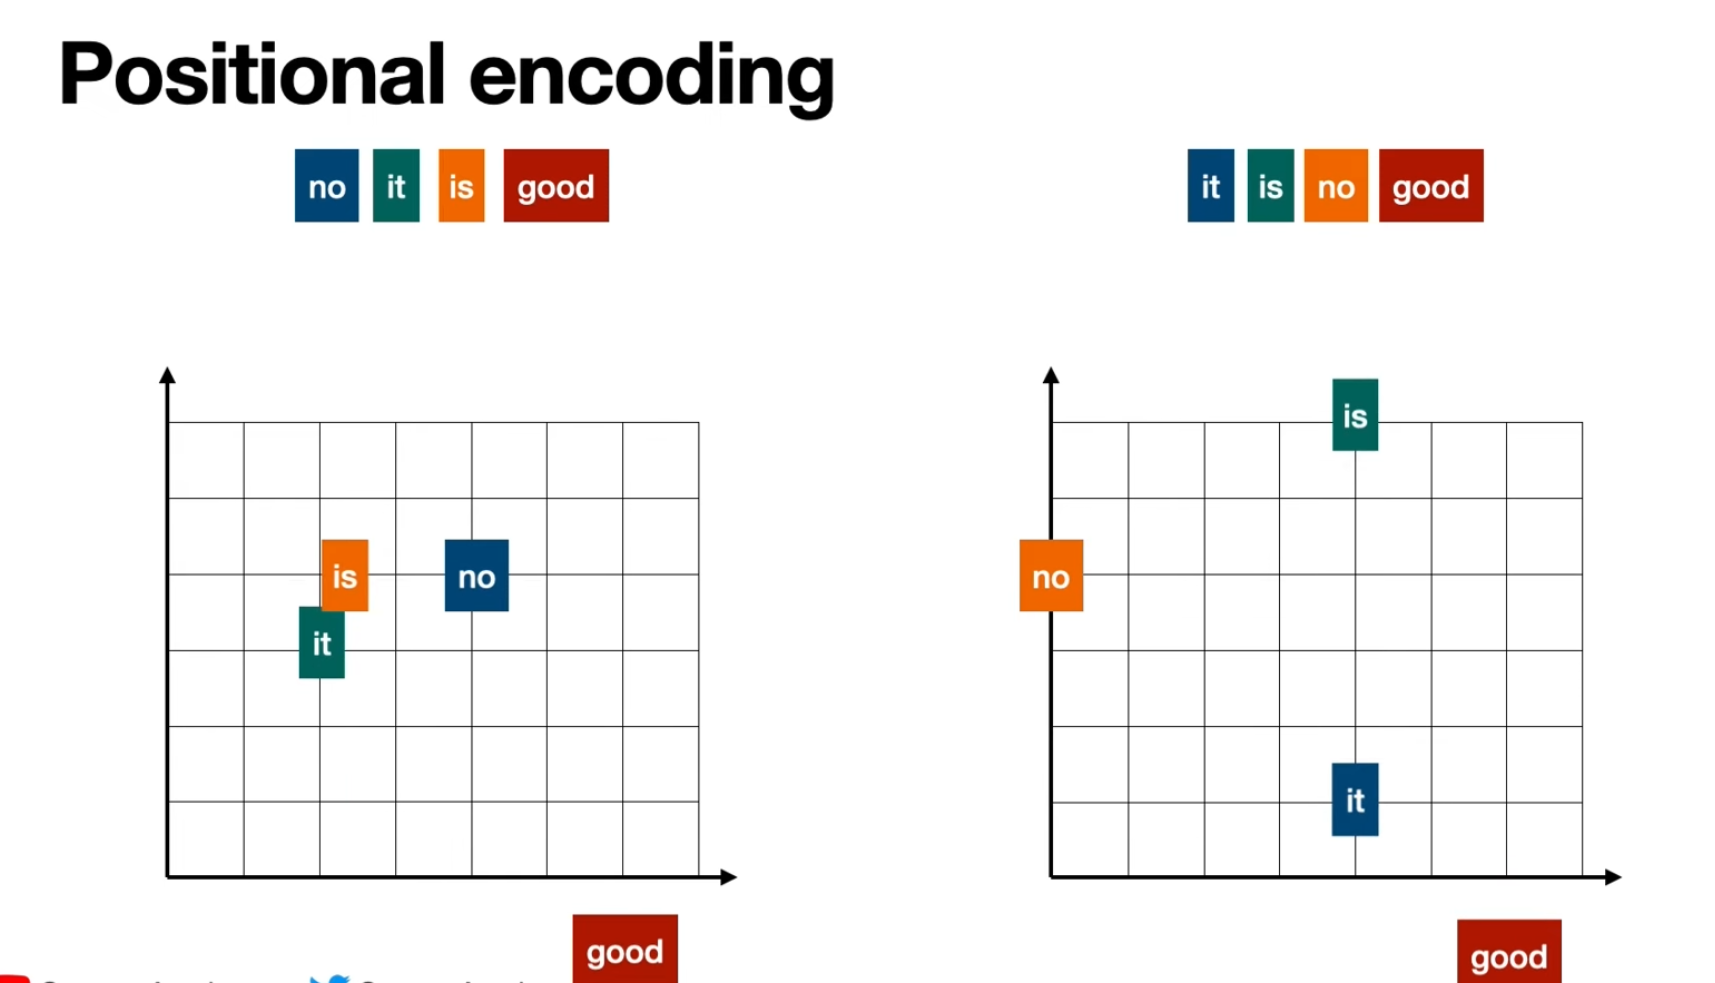

Trong ảnh trên thì các từ giống nhau đã có vector embedidng khác nhau, riêng từ `good` do vẫn ở vị trí thứ 4 cho cả 2 câu và đều là `good` nên vector embedding không thay đổi. Để làm được điều này ta sẽ cần 1 công thức nào đó mà có khả năng đo được sự khác biệt về vị trí giữa 2 từ.

## 3.1 Class PositionalEncoding (sin–cos)

### Ý tưởng

* Mỗi vị trí `pos` được ánh xạ thành **một vector tọa độ**
* Vector này có cùng số chiều với token embedding (`d_model`)
* Mỗi cặp chiều mã hóa **một tần số sin–cos**

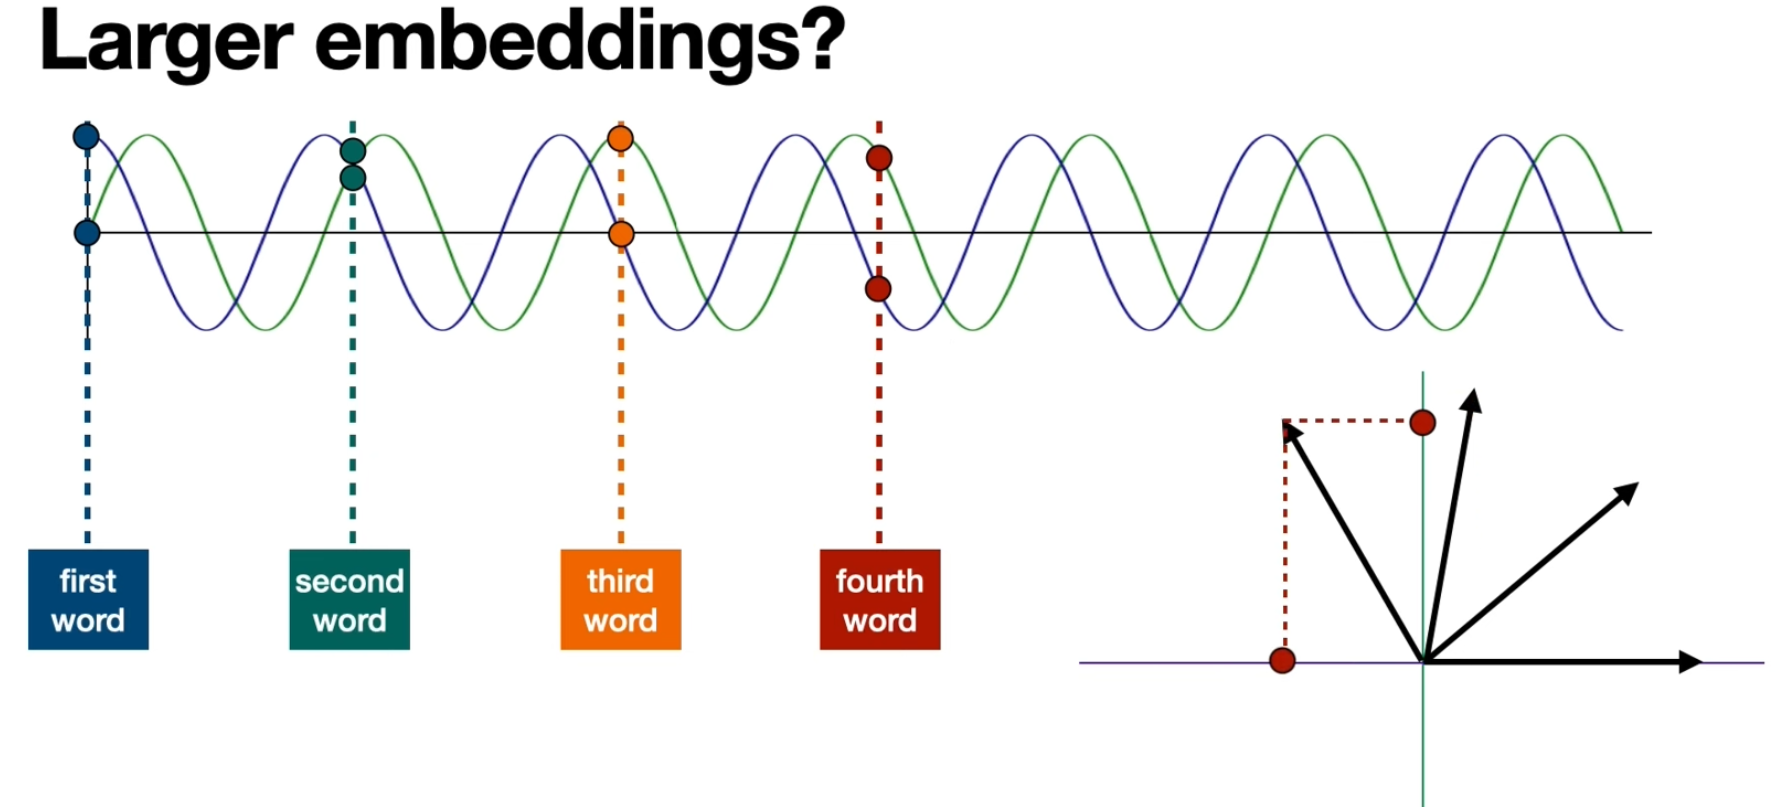


Ảnh trên là 1 ví dụ cho vector embedding có chiều = 2, mỗi cặp giá trị liên tiếp nhau trong vector embedding sẽ được tính là 1 tần số (gọi tần số vì nó được biểu diễn bởi lượng giác).

Có thể thấy với mỗi từ khác nhau thì sẽ có 1 vector embedding có giá trị khác nhau (trường hợp này vector embedding có 2 giá trị), 2 giá trị này sẽ thông qua công thức sau để biểu diễn tọa độ trên đồ thị lượng giác. Với `i = 0 → d_model/2 - 1`:

$$
PE(pos, 2i) = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)
$$

$$
PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)
$$

Trong đó:
- pos: vị trí từ (0 -> max len)
- i: là chỉ số chiều của vector embedding (0 -> d_model/2 - 1)
    - Chiều chẵn (2i) → dùng sin
    - Chiều lẻ (2i+1) → dùng cos


Ví dụ: Tại từ đầu tiên:
- pos = 0
    - i = 0 cho Sin
    - i = 1 cho Cos

Kết quả: Sin(0) = 0 | Cos(0) = 1 => Đây chính là tọa độ của vector từ đầu tiên (vector nằm ngang chỉ qua bên phải)

Khi chuyển qua biểu diễn trên đồ thị lượng giác, ta thấy tại từ đầu tiên có 2 đường (xanh lá - bắt đầu từ 0 - Sin) (xanh dương - bắt đầu từ 1 - Cos)

Tương tự cho các vị trí khác, và với mỗi pos (vị trí của từ), ta sẽ có 1 vector tọa độ (vector này có chiều bằng với vector embedidng, trong ảnh trên thì cả 2 đều = 2)

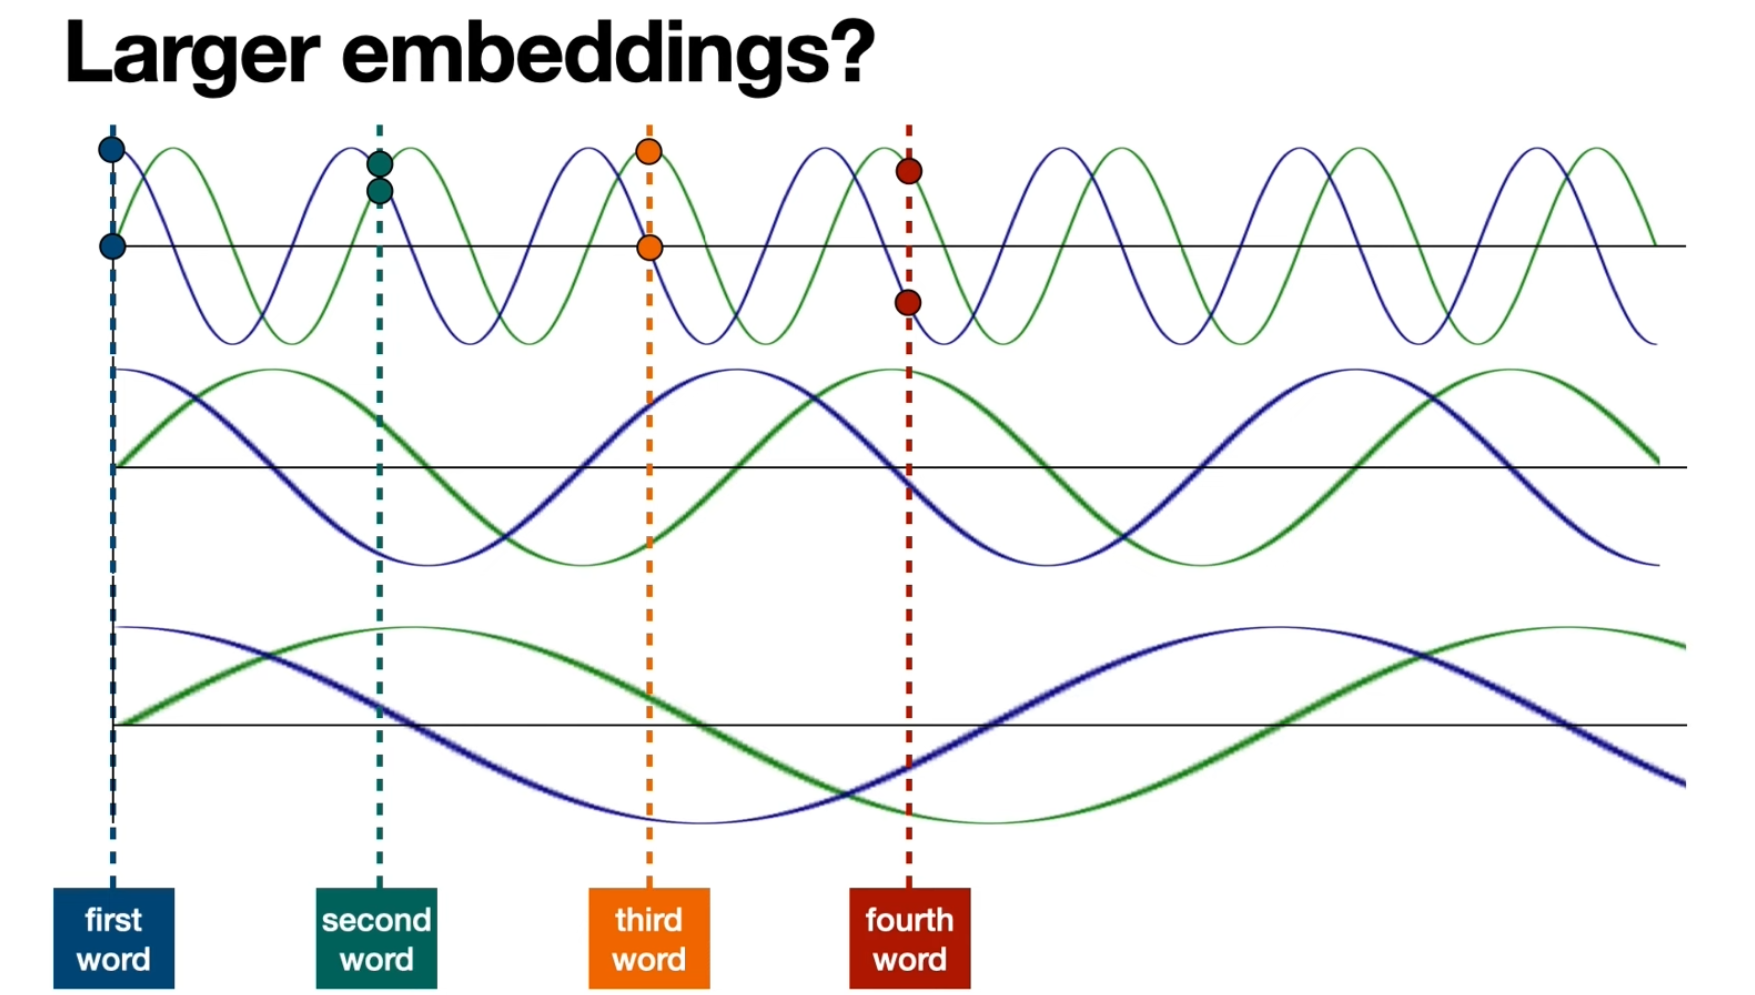

Ảnh trên là ví dụ cho vector embedding có 6 chiều, điều này đồng nghĩa với vector biểu diễn tọa độ trên đồ thị lượng giác cũng là 6 chiều. Các tần số bên dưới sẽ không biến động mạnh bằng các tần số ở bên trên,

Có công thức tần số góc: $ \omega_i = 10000^{-2i/d_{model}}$

>Vì giá trị i càng lớn thì $ \omega_i$ càng nhỏ - gần 0

> Và ngược lại khi i càng nhỏ thì $ \omega_i $ càng lớn - gần 1.

Khi $ \omega_i $ lớn (ví dụ = 0.98 => sin (pos/0.98)) thì sin/cos thay đổi nhanh theo pos => nhạy với khoảng cách nhỏ

Khi $ \omega_i $ nhỏ (Ví dụ = 0.01 => sin (pos/0.01)) thì sin/cos đổi rất chậm theo pos => mã hóa quan hệ xa

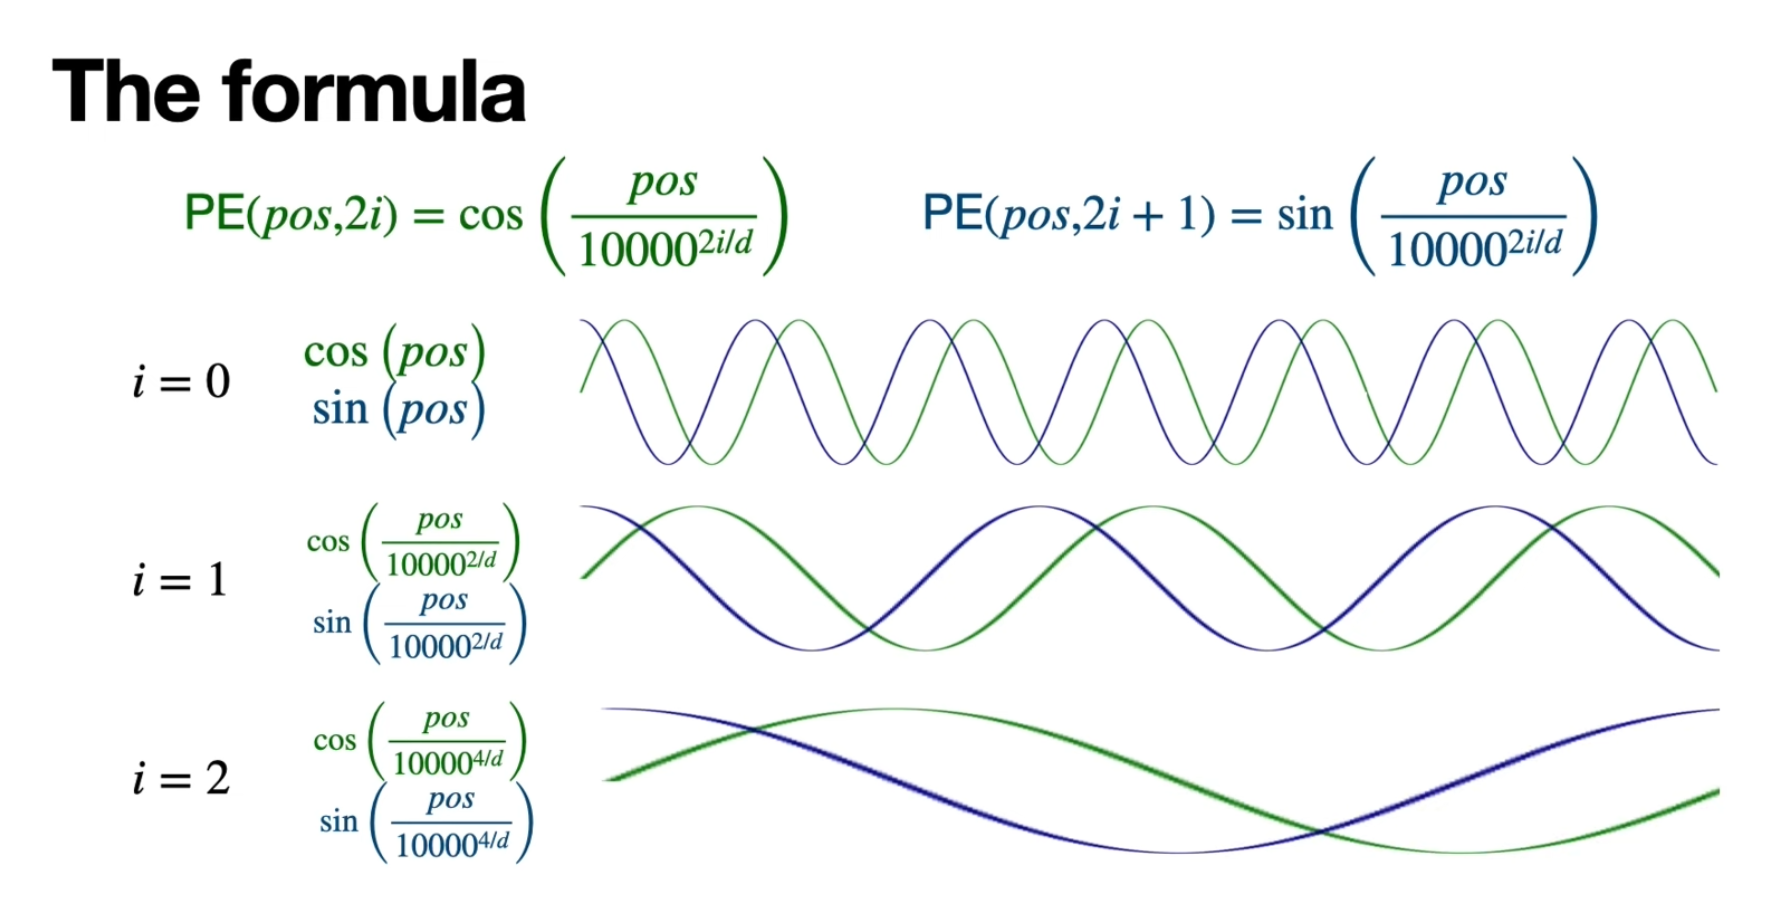

> Phải dùng 1 cặp sin/cos để biểu diễn vì nếu chỉ 1 hàm sin/cos thì sẽ xảy ra trường hợp trùng thông tin mã hóa vì chúng là hàm lượng giác tuần hoàn (khác pha nhưng trả về cùng 1 giá trị), việc có 1 cặp sin/ cos là để thể hiện tính tọa độ.

In [10]:
import torch
import torch.nn as nn
import math
from torch import Tensor

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int) -> None:
        super().__init__()

        # Tạo ma trận positional encoding [max_len, d_model]
        pe = torch.zeros(max_len, d_model)

        # Vector vị trí [0, 1, 2, ..., max_len-1]
        position = torch.arange(0, max_len).unsqueeze(1) # Biến đổi shape thành [max_len, 1] để sau nhân với div_term ra shape [max_len, d_model/2]

        # Vector tần số cách thông thường:
        div_term = 1 / (10000 ** (torch.arange(0, d_model, 2) / d_model))

        # Áp dụng sin cho chiều chẵn
        pe[:, 0::2] = torch.sin(position * div_term)

        # Áp dụng cos cho chiều lẻ
        pe[:, 1::2] = torch.cos(position * div_term)

        # Đưa về shape [1, max_len, d_model] để broadcast theo batch
        pe = pe.unsqueeze(0)

        # Register buffer: không train, nhưng đi theo model
        # pe không phải tham số cần học nên không backprop nhưng nó phải trong model để khi save/load model thì pe cũng được lưu theo
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        x: Tensor shape [batch_size, seq_len, d_model]
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :] # Cộng trực tiếp kiểu element-wise chứ không phải concat

## 3.2. Token Embedding + Positional Encoding

- Token embedding: mã hóa nội dung

- Positional encoding: mã hóa thứ tự

- Hai thứ được cộng tuyến tính, không concat

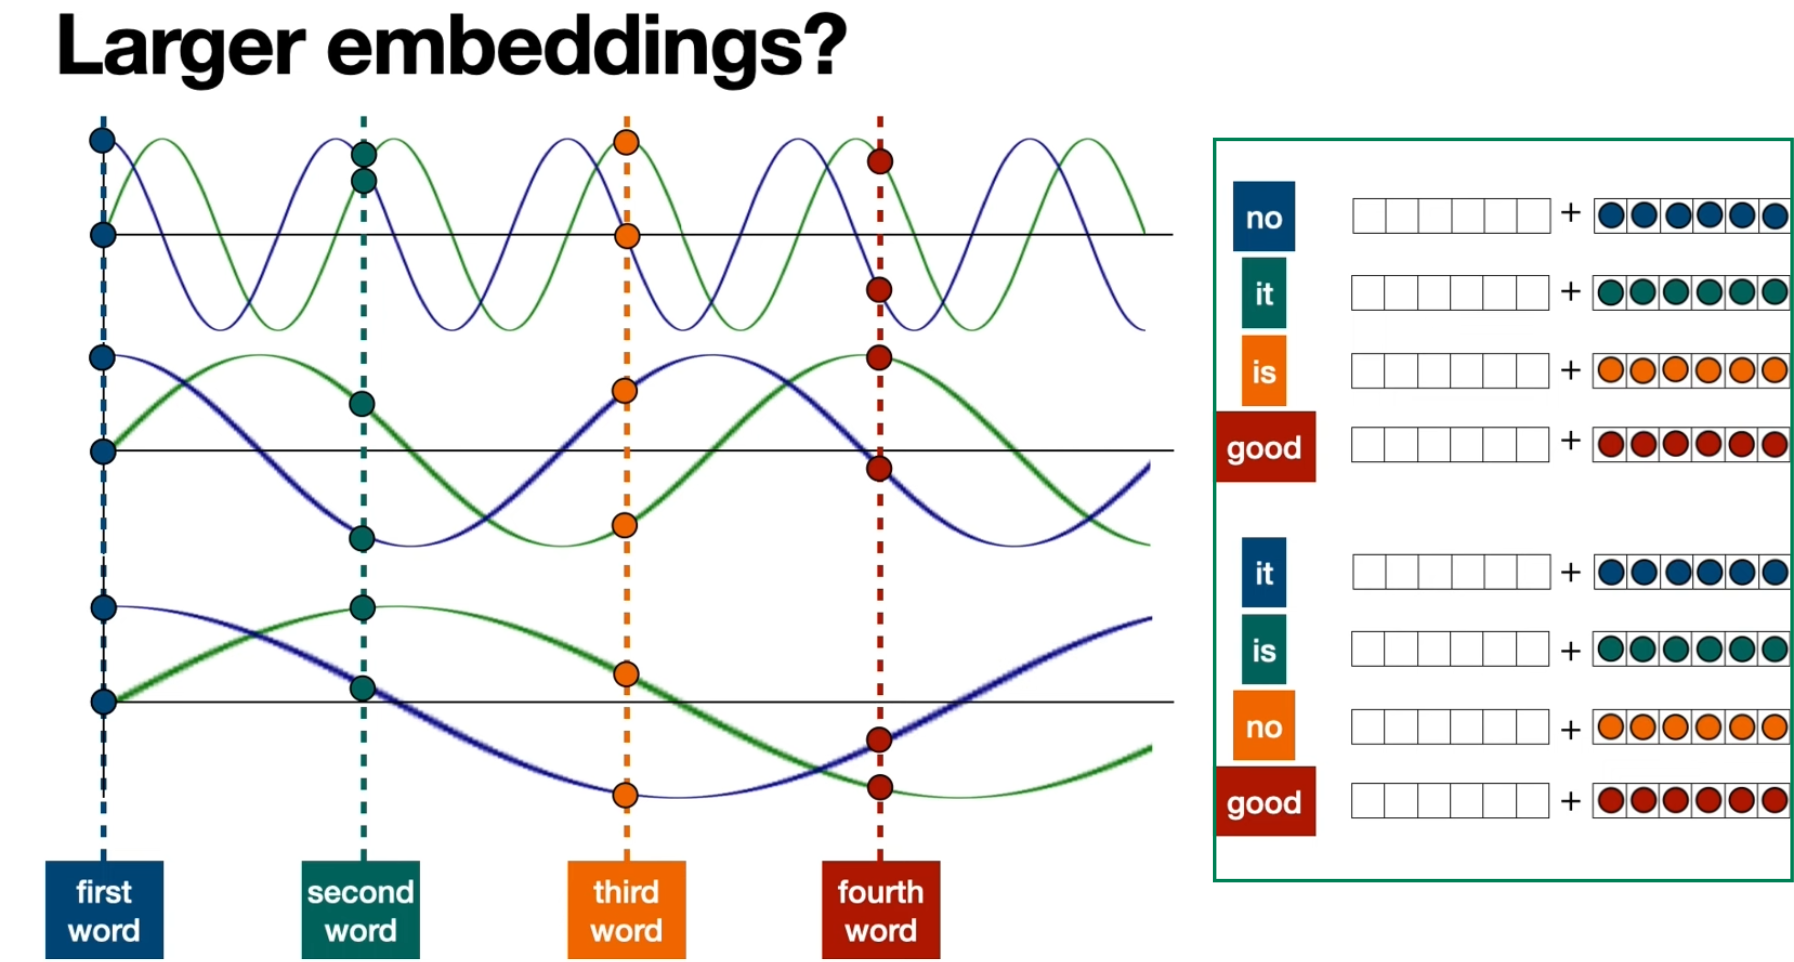

In [11]:
class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, max_len: int) -> None:
        super().__init__()

        # Embedding ánh xạ token id sang vector embedding
        self.token_embedding = nn.Embedding(vocab_size, d_model)

        # Positional Encoding - Không được train
        self.positional_encoding = PositionalEncoding(d_model, max_len)

    def forward(self, input_ids: Tensor) -> Tensor:
        """
        input_ids: [batch_size, seq_len]
        """
        x = self.token_embedding(input_ids)
        x = self.positional_encoding(x)
        return x

## 3.3. Sanity check Embedding + Positional Encoding

In [12]:
# Lấy thông số từ dữ liệu
VOCAB_SIZE = int(train_data["input_ids"].max().item()) + 1
print(VOCAB_SIZE)

D_MODEL = 256
MAX_LEN = train_data["input_ids"].shape[1]
print(MAX_LEN)

embedding_layer = EmbeddingLayer(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    max_len=MAX_LEN
)

# Test với 1 batch
batch = next(iter(train_loader))
embedded = embedding_layer(batch["input_ids"])

print("Embedding output shape:", embedded.shape)
# Embedding output shape: torch.Size([32, 128, 256])

248833
128
Embedding output shape: torch.Size([32, 128, 256])


# 4. Transformer Encoder (3 layers)

Vậy là ở trên ta đã xong phần positional encoding và embedding

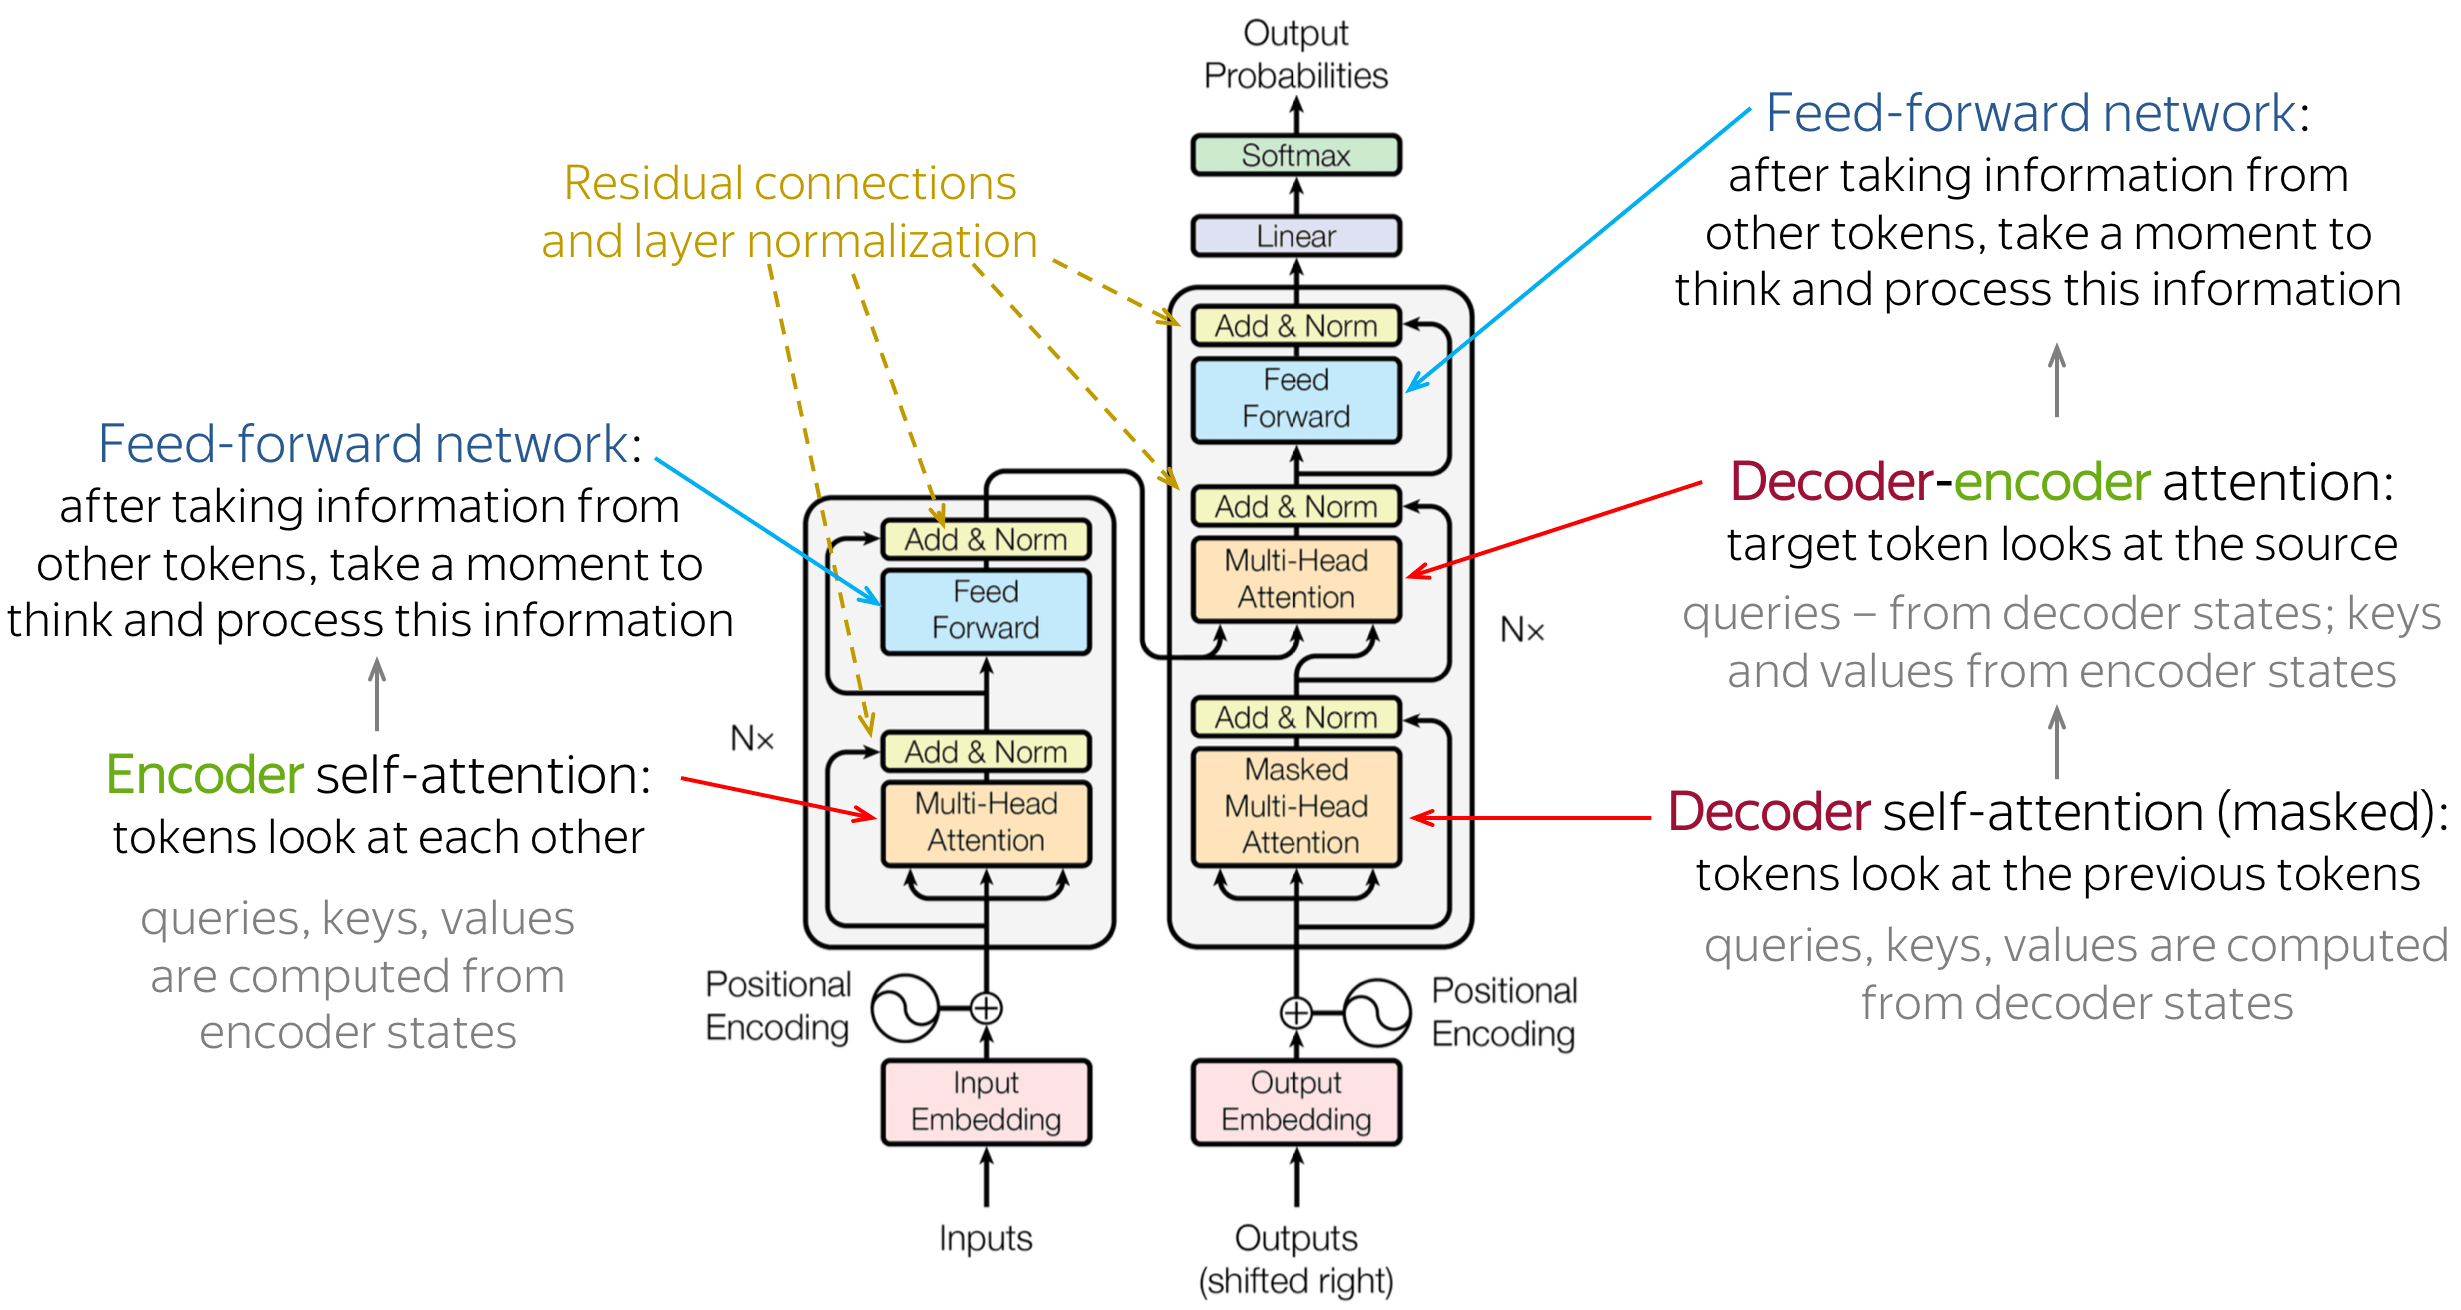

## 4.1. Multi-Head Self-Attention

Tổng quan cấu trúc một Transformer Encoder Layer

Một **Encoder Layer** gồm 2 khối chính:

1. **Multi-Head Self-Attention**
2. **Feed-Forward Network (FFN)**

Mỗi khối đều có:

* Residual connection
* Layer Normalization

### a. Tổng quan

- Khối này được áp dụng **sau Embedding + Positional Encoding**.
- Mục tiêu: cho mỗi token có thể **truy cập và tổng hợp thông tin từ toàn bộ các token khác** trong câu, không phụ thuộc khoảng cách.


### b. Ý tưởng: Attention được lấy ý tưởng từ hệ thống Information Retrieval

- Mỗi token đóng vai trò như một "truy vấn" (Query).
- Các token còn lại cung cấp "khóa" (Key) để so khớp.

>Ví dụ: Nếu nói Query là nội dung tìm kiêm vidoe trên youtube (phim hoạt hình), thì Key sẽ là các nhãn như (Cartoon, thiếu nhi, hài,...) Và ta đang muốn xem cái nào có độ liên quan tốt nhất, (attention map).

- Attention trả lời câu hỏi:
  "Token này nên chú ý đến token nào, và ở mức độ bao nhiêu?"
- Gọi là *self-attention* vì tập truy vấn và tập dữ liệu tìm kiếm là **chính câu đầu vào**. chứ không có copus ngoài


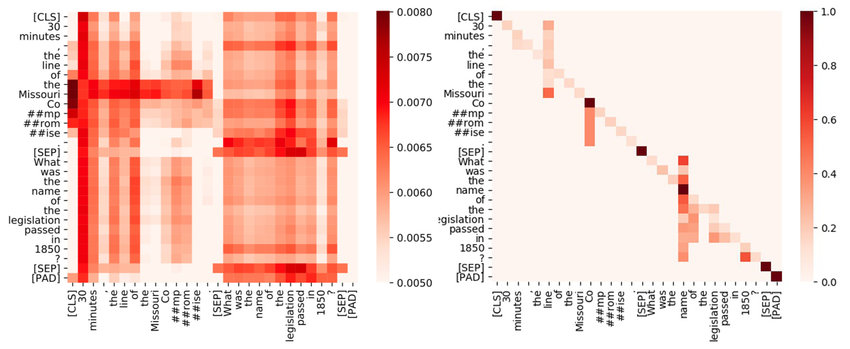

### c. Dữ liệu đầu vào (sau Positional Encoding)

- Đầu vào của Multi-Head Attention là ma trận X.
- Mỗi hàng của X tương ứng với **một token trong câu**.
- X đã chứa cả:
  - thông tin ngữ nghĩa (embedding)
  - thông tin vị trí (positional encoding)

Ký hiệu:
- L: số token trong câu
- d_model: chiều embedding
- X ∈ ℝ^{L × d_model}

Trong hình bên dưới là 1 câu có 2 từ và số chiều embedding (d_model) = 4.

(Thực tế cả 2 con số này sẽ lớn hơn, đặc biệt là d_model khi ta chia nhiều head để đọc thông tin)

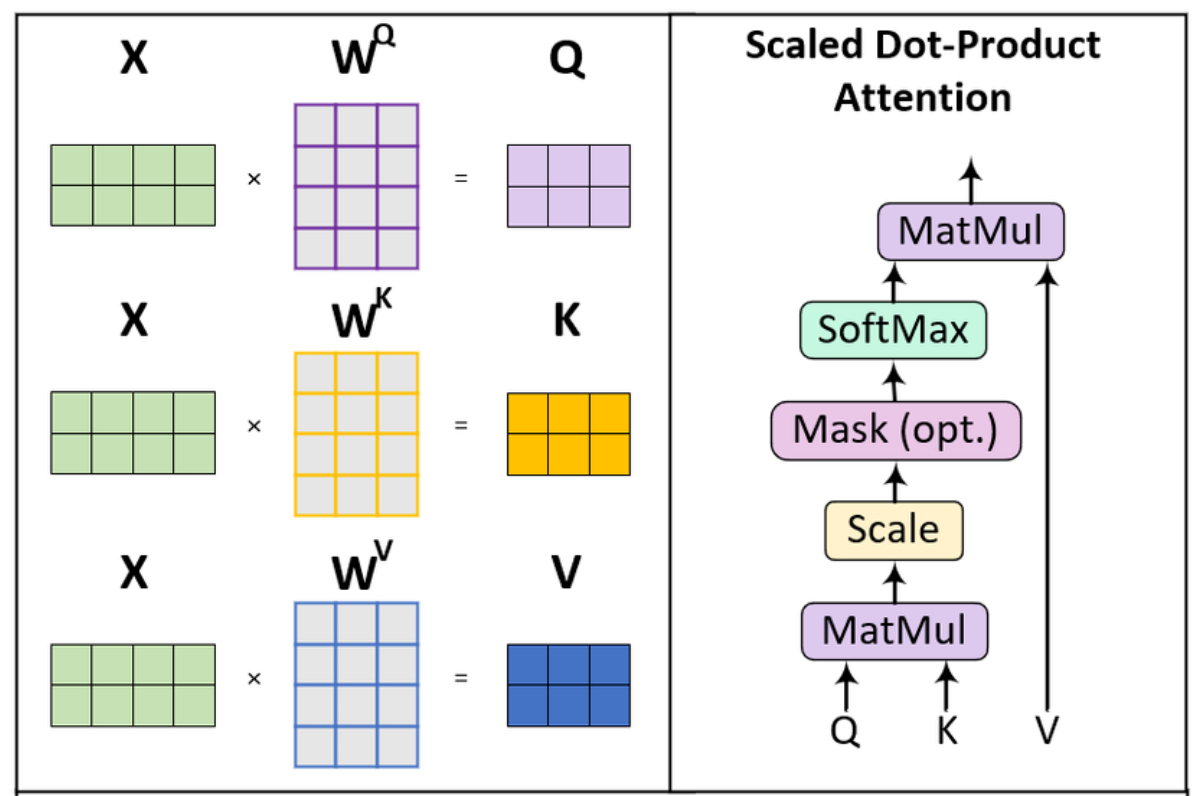

*Hình minh họa sử dụng kích thước nhỏ (L=2, d_k=3) để đơn giản hóa trực quan.
Trong thực tế, d_k = d_model / num_heads.*


### d. Tạo Query (Q), Key (K), Value (V)

Từ đầu vào $X$, Transformer tạo ra ba ma trận $Q$, $K$, $V$
thông qua các phép chiếu tuyến tính khác nhau:

$$
Q = X W^{Q}, \qquad
K = X W^{K}, \qquad
V = X W^{V}
$$

Trong đó:
- $W^{Q}, W^{K}, W^{V}$ là các ma trận trọng số học được (các lớp linear, được khởi tạo ngẫu nhiên theo một số phương pháp
  và ràng buộc phân phối nhất định).
- Các phép chiếu này cho phép cùng một token
  đảm nhận các vai trò khác nhau khi:
  - đặt câu hỏi (*Query*),
  - được so khớp (*Key*),
  - và truyền tải thông tin (*Value*).


### e. Số chiều trong Multi-Head Attention

Giả sử tổng quát:
- $X \in \mathbb{R}^{L \times d_{\text{model}}}$
- số head: $h$
- $d_k = \dfrac{d_{\text{model}}}{h}$

Khi đó, với mỗi head:
- $W^{Q} \in \mathbb{R}^{d_{\text{model}} \times d_k}$
- $W^{K} \in \mathbb{R}^{d_{\text{model}} \times d_k}$
- $W^{V} \in \mathbb{R}^{d_{\text{model}} \times d_k}$

Các phép chiếu tương ứng:
$$
Q = X W^{Q} \in \mathbb{R}^{L \times d_k}
$$
$$
K = X W^{K} \in \mathbb{R}^{L \times d_k}
$$
$$
V = X W^{V} \in \mathbb{R}^{L \times d_k}
$$

**Liên hệ với hình minh họa phía trên:**
- Hình sử dụng ví dụ minh họa với kích thước nhỏ để dễ quan sát.
- Trong hình:
  - $L = 2$ (2 token)
  - $d_{\text{model}} = 4$
  - số head = 1
  - $d_k = 3$ (chỉ dùng cho minh họa, không phải cấu hình thực tế)
- Số cột của $Q$, $K$, $V$ trong hình biểu diễn số chiều $d_k$ của mỗi head.
- Các giá trị trong hình chỉ mang tính trực quan, không phản ánh kích thước thật của mô hình.


### f. Scaled Dot-Product Attention

Từ Q và K, ta tính ma trận attention score:

$$
Z = \frac{QK^{\top}}{\sqrt{d_k}}, \quad Z \in \mathbb{R}^{L \times L}
$$

Trong đó, mỗi phần tử của ma trận Z được xác định bởi:

$$
Z_{ij} = \frac{q_i \cdot k_j}{\sqrt{d_k}}
$$

### Ý nghĩa các chỉ số
- $i$: chỉ số token đang đóng vai trò **query**
- $j$: chỉ số token đang đóng vai trò **key**
- $m$: chỉ số chiều embedding, $m = 1, \dots, d_k$

Với:
- $q_i \in \mathbb{R}^{d_k}$ là vector query của token $i$
- $k_j \in \mathbb{R}^{d_k}$ là vector key của token $j$

Phép tích vô hướng được tính như sau:

$$
q_i \cdot k_j = \sum_{m=1}^{d_k} q_{i,m} \, k_{j,m}
$$

Như vậy:
- mỗi $Z_{ij}$ đo mức độ liên quan giữa token $i$ và token $j$
- mỗi hàng của $Z$ biểu diễn mức độ chú ý của token $i$ tới toàn bộ các token trong câu


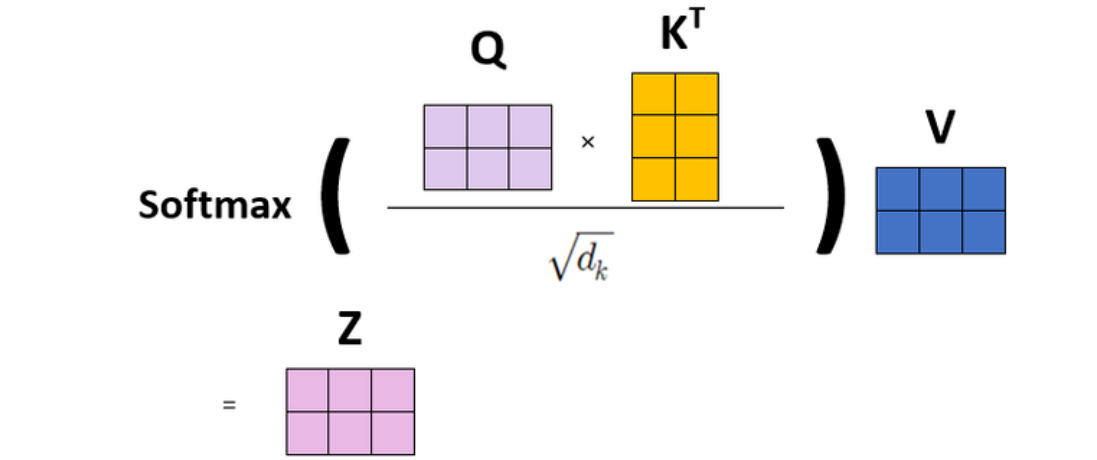

#### Scale trong Scaled Dot-Product Attention (Đặt vấn đề)

Trong Attention, mỗi phần tử của ma trận score được tính bởi:

$$
Z_{ij} = q_i \cdot k_j
$$

với:
- $q_i, k_j \in \mathbb{R}^{d_k}$

Viết lại tích vô hướng theo từng chiều embedding:

$$
Z_{ij} = \sum_{m=1}^{d_k} q_{i,m} k_{j,m}
$$

Khi $d_k$ lớn, mỗi $Z_{ij}$ là tổng của nhiều hạng tử,
khiến độ lớn của attention score tăng lên
không phải do các token liên quan hơn,
mà do số chiều embedding tăng. Thật ra thì không phải lúc nào `độ lớn của attention score cũng tăng lên`, mà là do khi $d_k$ lớn thì tích vô hướng sẽ là tổng của nhiều phép nhân hơn, nên thông thường đại lượng này sẽ có độ lớn lớn hơn và phương sai của các tích vô hướng khác nhau sẽ lớn hơn.

Để tránh tính trạng này ta cần phải chuẩn hóa bằng cách chia cho $\sqrt{d_k}$. Tại sao lại chia cho $\sqrt{d_k}$ sẽ được giải thích dưới đây.


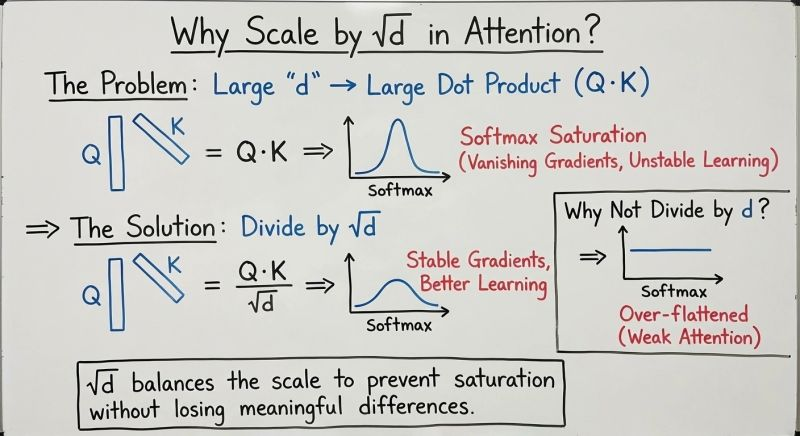

Softmax bị saturated khi attention logits đầu vò trở nên quá lớn, chia cho $d_k$ giúp chuẩn hóa và bảo toàn gradient khỏi gradient vanishing (Do input logit soft-max lớn nên hàm $e^$ bùng nổ, nên hầu như xác suất tại 1 lớp ~ 1 và các lớp khác ~ 0)

#### Phương sai của attention score

Giả sử tại thời điểm khởi tạo:
- $q_{i,m}$ là phần tử thứ $m$ của vector query $q_i$
- $k_{j,m}$ là phần tử thứ $m$ của vector key $k_j$
- $q_{i,m}$ và $k_{j,m}$ là **các số vô hướng (scalar)** và độc lập
- $\mathbb{E}[q_{i,m}] = \mathbb{E}[k_{j,m}] = 0$
- $\mathrm{Var}(q_{i,m}) = \mathrm{Var}(k_{j,m}) = 1$

Với $i, j$ cố định, tích vô hướng có thể viết lại theo từng chiều embedding:
$$
Z_{ij} = q_i \cdot k_j = \sum_{m=1}^{d_k} q_{i,m} k_{j,m}
$$

Đặt:
$$
X_m = q_{i,m} k_{j,m}
$$

trong đó $X_m$ là **tích của hai số vô hướng** tại chiều embedding thứ $m$.

Khi đó:
$$
\mathbb{E}[X_m] = 0, \qquad \mathrm{Var}(X_m) = 1
$$

Do:
$$
Z_{ij} = \sum_{m=1}^{d_k} X_m
$$

và các $X_m$ độc lập theo $m$, ta có:
$$
\mathrm{Var}(Z_{ij}) = d_k
$$


#### Chuẩn hóa bằng cách chia $\sqrt{d_k}$

Từ kết quả trước, ta có:
$$
\mathrm{Var}(Z_{ij}) = d_k
$$

Do đó, khi $d_k$ tăng, phương sai của attention score cũng tăng theo,
khiến các giá trị đưa vào Softmax trở nên quá lớn.

Để chuẩn hóa phương sai, Transformer sử dụng scaled dot-product attention:
$$
\tilde{Z}_{ij} = \frac{Z_{ij}}{\sqrt{d_k}}
$$

Sử dụng tính chất của phương sai:
$$
\mathrm{Var}(aX) = a^2 \mathrm{Var}(X)
$$

suy ra:
$$
\mathrm{Var}(\tilde{Z}_{ij})
= \frac{1}{d_k}\,\mathrm{Var}(Z_{ij})
= 1
$$

Nhờ đó:
- phương sai của attention score được đưa về cùng một mức (xấp xỉ 1)
- các trường hợp có $d_k$ khác nhau trở nên so sánh được
- Softmax hoạt động trong vùng ổn định, tránh bão hòa


### h. Kết hợp Attention Weights với Value

> V (Value) để làm gì?

**Q, K** chỉ dùng để **quyết định *ai* chú ý *ai***.
**V** mới là thứ **mang *nội dung thông tin* được truyền đi**.

Sau khi áp dụng Softmax, ta thu được ma trận trọng số attention:
$$
A = \text{softmax}(\tilde{Z}), \quad A \in \mathbb{R}^{L \times L}
$$

Ma trận output của attention trong một head được tính bằng:
$$
O = A V
$$

Trong đó:
- $V \in \mathbb{R}^{L \times d_k}$ là ma trận value
- $O \in \mathbb{R}^{L \times d_k}$ là output của attention trong **một head**

Ở mức token:
$$
o_i = \sum_{j=1}^{L} A_{ij} \, v_j
$$

Mỗi vector $o_i$ là tổ hợp tuyến tính có trọng số
của các value vector trong câu,
trong đó trọng số được quyết định bởi mức độ attention.

Nghĩa là:
* token (i) **không nhận thông tin từ Q hay K**
* nó **nhận tổ hợp tuyến tính của các vector (v_j)**

### i. Từ Single-Head đến Multi-Head Attention

Với $h$ head song song, ta thu được:
$$
O^{(1)}, O^{(2)}, \dots, O^{(h)}, \quad
O^{(i)} \in \mathbb{R}^{L \times d_k}
$$

Các output này được ghép lại theo chiều embedding:
$$
O_{\text{concat}} = \text{Concat}\left(O^{(1)}, \dots, O^{(h)}\right)
\in \mathbb{R}^{L \times (h \cdot d_k)}
$$

Sau đó, áp dụng một phép chiếu tuyến tính:
$$
O_{\text{final}} = O_{\text{concat}} W^{O},
\quad W^{O} \in \mathbb{R}^{(h \cdot d_k) \times d_{\text{model}}}
$$

Kết quả $O_{\text{final}}$ có cùng số chiều với đầu vào $X$
và là output cuối cùng của khối Multi-Head Attention.


### j. Tóm tắt khối Multi-Head Attention

Khối Multi-Head Attention bao gồm các bước:
1. Chiếu $X$ thành $Q, K, V$
2. Tính attention score $QK^\top / \sqrt{d_k}$
3. Softmax để thu được attention weights
4. Kết hợp weights với $V$ để tạo output cho từng head
5. Ghép các head và chiếu về $d_{\text{model}}$

Output của khối này được đưa tiếp vào:
- Add & Norm
- Feed-Forward Network (FFN)


## 4.2 Định nghĩa class MultiHeadSelfAttention

In [13]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int) -> None:
        """
        Args:
            d_model (int): kích thước embedding (vd: 256, 512)
            num_heads (int): số head attention (vd: 8)
        """
        super().__init__()

        # Điều kiện bắt buộc:
        # d_model phải chia hết cho num_heads
        assert d_model % num_heads == 0

        self.d_model: int = d_model
        self.num_heads: int = num_heads

        # Kích thước embedding của MỖI head
        # Ví dụ: d_model=256, num_heads=8 -> head_dim=32
        self.head_dim: int = d_model // num_heads

        # Linear chiếu từ x -> [Q | K | V]
        # Input : [B, L, d_model]
        # Output: [B, L, 3 * d_model]
        self.qkv_proj: nn.Linear = nn.Linear(d_model, 3 * d_model)

        # Linear cuối để gộp các head lại
        self.out_proj: nn.Linear = nn.Linear(d_model, d_model)

    def forward(self, x: Tensor, attention_mask: Tensor) -> Tensor:
        """
        Args:
            x (Tensor):
                shape [batch_size, seq_len, d_model]
                embedding đầu vào (đã cộng positional encoding)

            attention_mask (Tensor):
                shape [batch_size, seq_len]
                1 = token thật
                0 = padding token (không được attend)

        Returns:
            Tensor:
                shape [batch_size, seq_len, d_model]
        """

        # -------------------------
        # 1. Lấy kích thước cơ bản
        # -------------------------
        B, L, _ = x.size()   # B=batch_size, L=seq_len

        # -------------------------
        # 2. Tạo Q, K, V
        # -------------------------

        # Chiếu x thành QKV gộp
        # [B, L, d_model] -> [B, L, 3*d_model]
        qkv: Tensor = self.qkv_proj(x)

        # Tách Q, K, V và chia head
        # [B, L, 3*d_model]
        # -> [B, L, 3, num_heads, head_dim]
        qkv = qkv.reshape(B, L, 3, self.num_heads, self.head_dim)

        # Đổi trục để tiện tính attention
        # [B, L, 3, H, D]
        # -> [3, B, H, L, D]
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # Tách riêng từng tensor
        Q: Tensor = qkv[0]   # [B, H, L, D]
        K: Tensor = qkv[1]   # [B, H, L, D]
        V: Tensor = qkv[2]   # [B, H, L, D]

        # -------------------------
        # 3. Tính attention score
        # -------------------------

        # Q @ K^T
        # [B, H, L, D] @ [B, H, D, L]
        # -> [B, H, L, L]
        scores: Tensor = torch.matmul(Q, K.transpose(-2, -1))

        # Scaling để tránh gradient quá lớn
        scores = scores / math.sqrt(self.head_dim)

        # -------------------------
        # 4. Mask padding token
        # -------------------------

        # attention_mask: [B, L]
        # -> [B, 1, 1, L] để broadcast cho mọi head & query
        attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Gán -inf cho các vị trí padding
        scores = scores.masked_fill(attention_mask == 0, float("-inf"))

        # -------------------------
        # 5. Softmax để ra trọng số attention
        # -------------------------

        # Softmax theo chiều "key"
        attn_weights: Tensor = torch.softmax(scores, dim=-1)
        # shape: [B, H, L, L]

        # -------------------------
        # 6. Weighted sum với V
        # -------------------------

        # [B, H, L, L] @ [B, H, L, D]
        # -> [B, H, L, D]
        context: Tensor = torch.matmul(attn_weights, V)

        # -------------------------
        # 7. Gộp các head lại
        # -------------------------

        # [B, H, L, D] -> [B, L, H, D]
        context = context.transpose(1, 2).contiguous()

        # [B, L, H, D] -> [B, L, d_model]
        context = context.view(B, L, self.d_model)

        # -------------------------
        # 8. Linear cuối
        # -------------------------

        # Trộn thông tin từ các head
        return self.out_proj(context)

## 4.3. Feed-Forward Network (FFN)

Sau khi Multi-Head Attention đã tổng hợp thông tin
giữa các token, mỗi token cần được **xử lý sâu về mặt đặc trưng**.

Feed-Forward Network (FFN) thực hiện:
- biến đổi phi tuyến
- áp dụng **độc lập cho từng token**
- không trao đổi thông tin giữa các token

FFN giúp tăng khả năng biểu diễn của mô hình,
bổ sung năng lực mà Attention (chỉ là tổ hợp tuyến tính) không có.
Cấu trúc:

```
Linear → ReLU → Linear
```

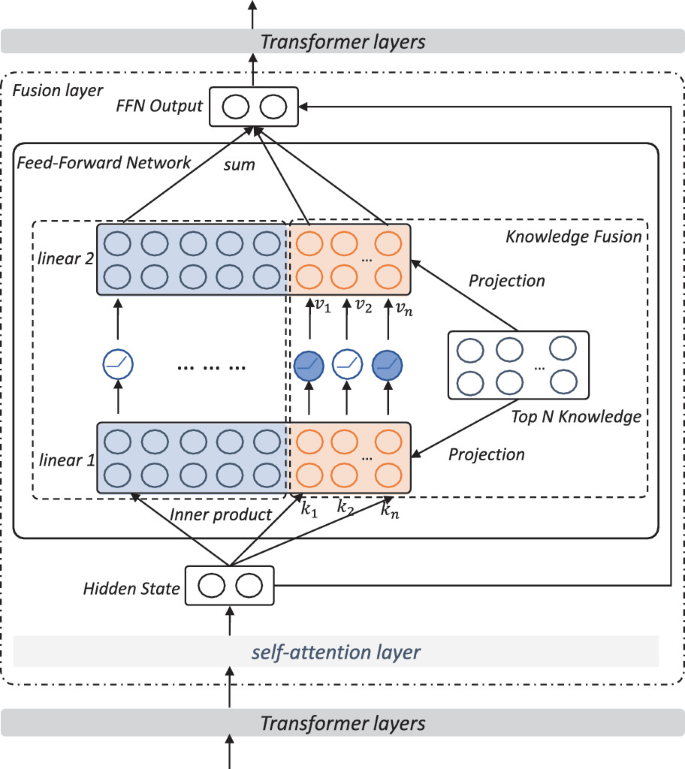

*Hình minh họa cấu trúc Feed-Forward Network và cơ chế xử lý đặc trưng
sau Self-Attention trong một Transformer layer.*

### a. Cấu trúc toán học của Feed-Forward Network (FFN)

Như minh họa trong hình Feed-Forward Network phía trên,
FFN nhận đầu vào là hidden state của từng token
(sau self-attention layer).

Với mỗi token vector $x \in \mathbb{R}^{d_{\text{model}}}$,
FFN được định nghĩa bởi hai phép chiếu tuyến tính
(khối linear 1 và linear 2):

$$
\text{FFN}(x) = W_2 \, \sigma(W_1 x + b_1) + b_2
$$

Trong đó:
- $W_1 \in \mathbb{R}^{d_{\text{model}} \times d_{\text{ff}}}$  
  (tương ứng với khối *linear 1* – mở rộng chiều)
- $W_2 \in \mathbb{R}^{d_{\text{ff}} \times d_{\text{model}}}$  
  (tương ứng với khối *linear 2* – thu chiều về lại)
- $\sigma(\cdot)$ là hàm phi tuyến (ReLU)


### b. Số chiều trong Feed-Forward Network

Trong thực tế, số chiều của FFN thường được chọn sao cho:
$$
d_{\text{ff}} \approx 4 \times d_{\text{model}}
$$

Số 4 ở đây là chọn 1 số để cân bằng giữa khả năng biểu diễn phi tuyến và tài nguyên tính toán, này là đánh đổi.


Trong bài báo có đề cập:
- 2×: thiếu capacity

- 4×: best trade-off

- 8×: tăng ít chất lượng, nhưng chi phí tăng mạnh

Ví dụ:
- $d_{\text{model}} = 256$
- $d_{\text{ff}} = 1024$


### c. FFN là Position-wise Network

Trong hình trên, mỗi hidden state đi vào FFN
được xử lý độc lập, không có kết nối giữa các token.

Về mặt toán học:
$$
X \in \mathbb{R}^{L \times d_{\text{model}}}
\quad\Rightarrow\quad
\text{FFN}(X) \in \mathbb{R}^{L \times d_{\text{model}}}
$$

Trong đó:
- mỗi hàng của $X$ (mỗi token) đi qua cùng một FFN
- không có sự trao đổi thông tin giữa các token trong khối này

Điều này phù hợp với luồng trong hình:
- self-attention đảm nhiệm việc trao đổi thông tin
- FFN đảm nhiệm việc biến đổi sâu đặc trưng của từng token

In [14]:
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int) -> None:
        """
        Args:
            d_model: kích thước embedding
            d_ff: kích thước tầng ẩn (thường = 4 * d_model)
        """
        super().__init__()

        # Áp dụng độc lập cho từng token
        # [B, L, d_model] -> [B, L, d_model]
        self.net: nn.Sequential = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor [batch_size, seq_len, d_model]
        Returns:
            Tensor [batch_size, seq_len, d_model]
        """
        return self.net(x)

## 4.4. Transformer Encoder Layer

In [15]:
class TransformerEncoderLayer(nn.Module):
    def __init__(
        self,
        d_model: int,
        num_heads: int,
        d_ff: int,
        dropout: float = 0.2
    ) -> None:
        """
        Args:
            d_model: kích thước embedding
            num_heads: số head attention
            d_ff: kích thước tầng ẩn FFN
            dropout: tỉ lệ dropout
        """
        super().__init__()

        # Multi-head self-attention
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)

        # Feed-forward network
        self.ffn = FeedForward(d_model, d_ff)

        # LayerNorm cho residual connection
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor, attention_mask: Tensor) -> Tensor:
        """
        Args:
            x: Tensor [batch_size, seq_len, d_model]
            attention_mask: Tensor [batch_size, seq_len]

        Returns:
            Tensor [batch_size, seq_len, d_model]
        """

        # 1. Self-attention + residual + norm
        attn_out: Tensor = self.self_attn(x, attention_mask)
        x: Tensor = self.norm1(x + self.dropout(attn_out))

        # 2. Feed-forward + residual + norm
        ffn_out: Tensor = self.ffn(x)
        x: Tensor = self.norm2(x + self.dropout(ffn_out))

        return x

## 4.5. Stack 3 Encoder Layers

In [16]:
class TransformerEncoder(nn.Module):
    def __init__(
        self,
        num_layers: int,
        d_model: int,
        num_heads: int,
        d_ff: int,
        dropout: float = 0.2
    ) -> None:
        """
        Args:
            num_layers: số encoder layer
            d_model: kích thước embedding
            num_heads: số head attention
            d_ff: kích thước tầng ẩn FFN
            dropout: tỉ lệ dropout
        """
        super().__init__()

        # Stack nhiều TransformerEncoderLayer
        self.layers: nn.ModuleList = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x: Tensor, attention_mask: Tensor) -> Tensor:
        """
        Args:
            x: Tensor [batch_size, seq_len, d_model]
            attention_mask: Tensor [batch_size, seq_len]

        Returns:
            Tensor [batch_size, seq_len, d_model]
        """

        # Lần lượt cho dữ liệu đi qua từng encoder layer
        for layer in self.layers:
            x = layer(x, attention_mask)

        return x

## 4.6. Sanity check Transformer Encoder

In [17]:
NUM_LAYERS = 3
NUM_HEADS = 8
D_FF = 1024

encoder = TransformerEncoder(
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    d_ff=D_FF
)

encoder_out = encoder(embedded, batch["attention_mask"])

print("Encoder output shape:", encoder_out.shape)
# Encoder output shape: torch.Size([32, 128, 256])

Encoder output shape: torch.Size([32, 128, 256])


## 5. Pooling & Classification Head

* Chuyển biểu diễn **token-level** → **sentence-level**
* Ánh xạ sang **nhãn domain**
* Chuẩn bị **loss + các thành phần tối ưu** cho huấn luyện

Luồng tổng quát:

```
Encoder output [B, L, d_model]
→ Pooling
→ Sentence representation [B, d_model]
→ Linear
→ Logits [B, num_classes]
→ Loss
```

## 5.1. Pooling từ chuỗi token sang vector câu

In [18]:
class MeanPooling(nn.Module):
    def forward(self, x, attention_mask):
        """
        x: [batch_size, seq_len, d_model]
        attention_mask: [batch_size, seq_len]
        """
        mask = attention_mask.unsqueeze(-1)  # [B, L, 1]
        x = x * mask

        summed = x.sum(dim=1)                # [B, d_model]
        counts = mask.sum(dim=1)             # [B, 1]

        return summed / counts.clamp(min=1e-9)

## 5.2. Classification Head

In [19]:
class ClassificationHead(nn.Module):
    def __init__(self, d_model, num_classes, dropout=0.2):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.norm(x)
        x = self.dropout(x)
        return self.fc(x)   # logits

## 5.3. Ghép toàn bộ thành mô hình hoàn chỉnh

In [20]:
class TransformerClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        max_len,
        d_model,
        num_heads,
        num_layers,
        d_ff,
        num_classes,
        dropout=0.2
    ):
        super().__init__()

        self.embedding = EmbeddingLayer(vocab_size, d_model, max_len)
        self.encoder = TransformerEncoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            d_ff=d_ff,
            dropout=dropout
        )
        self.pooling = MeanPooling()
        self.classifier = ClassificationHead(d_model, num_classes, dropout)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.encoder(x, attention_mask)
        x = self.pooling(x, attention_mask)
        logits = self.classifier(x)
        return logits

In [21]:
def build_model():
    return TransformerClassifier(
        vocab_size=VOCAB_SIZE,
        max_len=MAX_LEN,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        num_layers=3,
        d_ff=D_FF,
        num_classes=NUM_CLASSES
    ).to(device)

## 5.5. Loss function & các kỹ thuật tối ưu (CHƯA TRAIN)

In [22]:
criterion_CrossEntropyLoss = nn.CrossEntropyLoss()

In [23]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing

    def forward(self, logits, target):
        """
        logits: [B, num_classes]
        target: [B]
        """
        log_probs = torch.log_softmax(logits, dim=-1)

        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)

        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

In [25]:
criterion_LabelSmoothingLoss = LabelSmoothingLoss(
    num_classes=NUM_CLASSES,
    smoothing=0.05
)

# 6. Huấn luyện & Đánh giá mô hình.

## 6.1. Chuẩn bị device và đưa model lên device

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 6.2. Các hàm metric (Accuracy & F1-score)

In [27]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_micro": f1_score(y_true, y_pred, average="micro")
    }

## 6.3. Định nghĩa class Trainer để Training + evaluating (loss + F1)

In [28]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        criterion,
        device,
        train_loader,
        val_loader,
        metric_fn,
        save_path="best_model.pt"
    ):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.metric_fn = metric_fn
        self.save_path = save_path

        self.best_f1 = 0.0
        self.train_losses = []
        self.val_losses = []
        self.val_f1s = []

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0

        for batch in self.train_loader:
            self.optimizer.zero_grad()

            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)

            logits = self.model(input_ids, attention_mask)
            loss = self.criterion(logits, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            total_loss += loss.item()

        return total_loss / len(self.train_loader)

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in self.val_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)

                logits = self.model(input_ids, attention_mask)
                loss = self.criterion(logits, labels)

                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        metrics = self.metric_fn(all_labels, all_preds)
        return total_loss / len(self.val_loader), metrics

    def fit(self, epochs):
        for epoch in range(1, epochs + 1):
            train_loss = self.train_one_epoch()
            val_loss, metrics = self.evaluate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_f1s.append(metrics["f1_macro"])

            print(
                f"Epoch {epoch:02d} | "
                f"Train Loss: {train_loss:.4f} | "
                f"Val Loss: {val_loss:.4f} | "
                f"Val F1: {metrics['f1_macro']:.4f}"
            )

            if metrics["f1_macro"] > self.best_f1:
                self.best_f1 = metrics["f1_macro"]
                torch.save(self.model.state_dict(), self.save_path)
                print("→ Saved best model")


## 6.4 Training Mô hình

### a. Experiment 1 – CrossEntropy (Baseline)

In [29]:
model_ce = build_model()

optimizer_ce = torch.optim.AdamW(
    model_ce.parameters(),
    lr=2e-4,
    weight_decay=1e-2
)

trainer_ce = Trainer(
    model=model_ce,
    optimizer=optimizer_ce,
    criterion=criterion_CrossEntropyLoss,
    device=device,
    train_loader=train_loader,
    val_loader=dev_loader,
    metric_fn=compute_metrics,
    save_path="CrossEntropyLoss_best_transformer_model.pt"
)

trainer_ce.fit(epochs=20)

Epoch 01 | Train Loss: 0.7684 | Val Loss: 0.4527 | Val F1: 0.6973
→ Saved best model
Epoch 02 | Train Loss: 0.4124 | Val Loss: 0.4341 | Val F1: 0.7491
→ Saved best model
Epoch 03 | Train Loss: 0.2971 | Val Loss: 0.3340 | Val F1: 0.8315
→ Saved best model
Epoch 04 | Train Loss: 0.2310 | Val Loss: 0.3040 | Val F1: 0.8351
→ Saved best model
Epoch 05 | Train Loss: 0.1977 | Val Loss: 0.3737 | Val F1: 0.8338
Epoch 06 | Train Loss: 0.1550 | Val Loss: 0.4149 | Val F1: 0.8414
→ Saved best model
Epoch 07 | Train Loss: 0.1158 | Val Loss: 0.4130 | Val F1: 0.8468
→ Saved best model
Epoch 08 | Train Loss: 0.0882 | Val Loss: 0.5164 | Val F1: 0.8228
Epoch 09 | Train Loss: 0.0894 | Val Loss: 0.4987 | Val F1: 0.8164
Epoch 10 | Train Loss: 0.0725 | Val Loss: 0.4807 | Val F1: 0.8345
Epoch 11 | Train Loss: 0.0541 | Val Loss: 0.5248 | Val F1: 0.8545
→ Saved best model
Epoch 12 | Train Loss: 0.0499 | Val Loss: 0.5831 | Val F1: 0.8278
Epoch 13 | Train Loss: 0.0525 | Val Loss: 0.6272 | Val F1: 0.8233
Epoch 14 

### b. Experiment 2 – Label Smoothing

In [30]:
model_ls = build_model()

optimizer_ls = torch.optim.AdamW(
    model_ls.parameters(),
    lr=2e-4,
    weight_decay=1e-2
)

trainer_ls = Trainer(
    model=model_ls,
    optimizer=optimizer_ls,
    criterion=criterion_LabelSmoothingLoss,
    device=device,
    train_loader=train_loader,
    val_loader=dev_loader,
    metric_fn=compute_metrics,
    save_path="LabelSmoothingLoss_best_transformer_model.pt"
)

trainer_ls.fit(epochs=20)

Epoch 01 | Train Loss: 0.8684 | Val Loss: 0.6376 | Val F1: 0.6826
→ Saved best model
Epoch 02 | Train Loss: 0.5716 | Val Loss: 0.5421 | Val F1: 0.8020
→ Saved best model
Epoch 03 | Train Loss: 0.4882 | Val Loss: 0.5582 | Val F1: 0.8004
Epoch 04 | Train Loss: 0.4306 | Val Loss: 0.5159 | Val F1: 0.8203
→ Saved best model
Epoch 05 | Train Loss: 0.3928 | Val Loss: 0.5779 | Val F1: 0.7965
Epoch 06 | Train Loss: 0.3600 | Val Loss: 0.5263 | Val F1: 0.8336
→ Saved best model
Epoch 07 | Train Loss: 0.3431 | Val Loss: 0.5705 | Val F1: 0.8155
Epoch 08 | Train Loss: 0.3281 | Val Loss: 0.5851 | Val F1: 0.8231
Epoch 09 | Train Loss: 0.3192 | Val Loss: 0.5783 | Val F1: 0.8090
Epoch 10 | Train Loss: 0.3116 | Val Loss: 0.5781 | Val F1: 0.8217
Epoch 11 | Train Loss: 0.2954 | Val Loss: 0.6104 | Val F1: 0.8233
Epoch 12 | Train Loss: 0.2897 | Val Loss: 0.5845 | Val F1: 0.8148
Epoch 13 | Train Loss: 0.2914 | Val Loss: 0.6265 | Val F1: 0.8400
→ Saved best model
Epoch 14 | Train Loss: 0.2870 | Val Loss: 0.599

## 6.5. Plot Training Validation loss + F1

In [31]:
import matplotlib.pyplot as plt

def plot_training_curves(trainer, title="Training Curves"):
    epochs = range(1, len(trainer.train_losses) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ---- Plot 1: Loss ----
    axes[0].plot(epochs, trainer.train_losses, label="Train Loss")
    axes[0].plot(epochs, trainer.val_losses, label="Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training & Validation Loss")
    axes[0].legend()
    axes[0].grid(True)

    # ---- Plot 2: F1 Macro ----
    axes[1].plot(epochs, trainer.val_f1s, label="Validation F1 (Macro)", color="tab:green")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("F1-score")
    axes[1].set_title("Validation F1-score")
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

### a. Experiment 1 – CrossEntropy (Baseline)

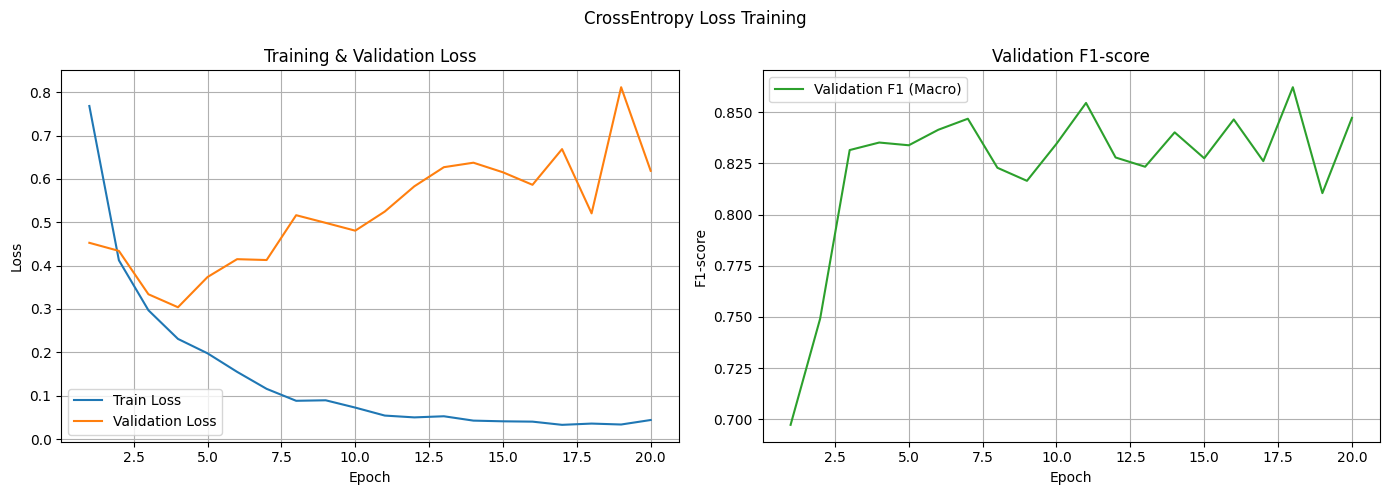

In [32]:
plot_training_curves(
    trainer_ce,
    title="CrossEntropy Loss Training"
)

> Val loss biến động mạnh, sau các epoch đầu val loss tăng trở lại, dấu hiệu overfiting cực mạnh, Val F1 cũng tương tự

### b. Experiment 2 – Label Smoothing

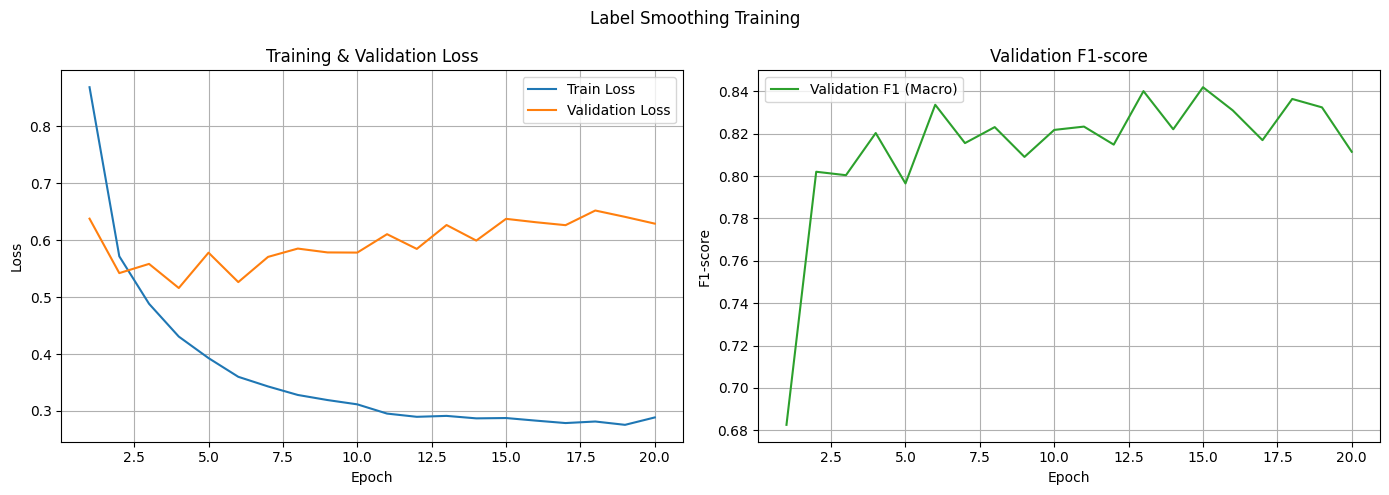

In [33]:
plot_training_curves(
    trainer_ls,
    title="Label Smoothing Training"
)

> Val Loss của Label Smoothing ít biến động hơn đúng với mong đợi, mặc dù có overfiting nhẹ. F1 val đạt ngưỡng 0.85 và ổn định hơn Cross Entropy loss thông thường.

## 6.6. Load lại best model và đánh giá trên Test set

In [34]:
def evaluate_on_test(
    model,
    test_loader,
    criterion,
    device,
    model_path
):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    metrics = compute_metrics(all_labels, all_preds)
    avg_loss = total_loss / len(test_loader)

    return avg_loss, metrics, all_labels, all_preds

In [35]:
test_results = {}

def run_test_experiment(
    name,
    model,
    model_path,
    criterion
):
    test_loss, test_metrics, y_true, y_pred = evaluate_on_test(
        model=model,
        test_loader=test_loader,
        criterion=criterion,
        device=device,
        model_path=model_path
    )

    test_results[name] = {
        "loss": test_loss,
        "metrics": test_metrics,
        "y_true": y_true,
        "y_pred": y_pred
    }

    print(f"\n===== Test results: {name} =====")
    print(f"Test Loss: {test_loss:.4f}")
    for k, v in test_metrics.items():
        print(f"{k}: {v:.4f}")

### a. Experiment 1 – CrossEntropy (Baseline)

In [36]:
run_test_experiment(
    name="CrossEntropy",
    model=model_ce,
    model_path="CrossEntropyLoss_best_transformer_model.pt",
    criterion=criterion_CrossEntropyLoss
)


===== Test results: CrossEntropy =====
Test Loss: 0.5070
accuracy: 0.8980
f1_macro: 0.8792
f1_micro: 0.8980


### b. Experiment 2 – Label Smoothing

In [37]:
run_test_experiment(
    name="LabelSmoothing",
    model=model_ls,
    model_path="LabelSmoothingLoss_best_transformer_model.pt",
    criterion=criterion_LabelSmoothingLoss
)


===== Test results: LabelSmoothing =====
Test Loss: 0.5757
accuracy: 0.8962
f1_macro: 0.8668
f1_micro: 0.8962


## 6.7 Classification Report

In [38]:
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred, digits=4):
    print(
        classification_report(
            y_true,
            y_pred,
            digits=digits
        )
    )

for name, result in test_results.items():
    print(f"\n===== Classification report: {name} =====")
    print_classification_report(
        result["y_true"],
        result["y_pred"]
    )


===== Classification report: CrossEntropy =====
              precision    recall  f1-score   support

           0     0.9891    0.9330    0.9602       194
           1     0.8978    0.8200    0.8571       150
           2     0.8261    0.9560    0.8863       159
           3     0.8222    0.8043    0.8132        46

    accuracy                         0.8980       549
   macro avg     0.8838    0.8783    0.8792       549
weighted avg     0.9030    0.8980    0.8983       549


===== Classification report: LabelSmoothing =====
              precision    recall  f1-score   support

           0     0.9643    0.9742    0.9692       194
           1     0.9154    0.7933    0.8500       150
           2     0.8418    0.9371    0.8869       159
           3     0.7609    0.7609    0.7609        46

    accuracy                         0.8962       549
   macro avg     0.8706    0.8664    0.8668       549
weighted avg     0.8984    0.8962    0.8954       549



>Thực nghiệm cho thấy LabelSmoothing cho kết quả F1 tốt hơn.

## 6.8. Lưu lại log

In [39]:
import json

def save_training_log(trainer, save_path):
    log = {
        "train_loss": trainer.train_losses,
        "val_loss": trainer.val_losses,
        "val_f1_macro": trainer.val_f1s,
        "best_val_f1": trainer.best_f1
    }

    with open(save_path, "w") as f:
        json.dump(log, f, indent=2)


In [40]:
save_training_log(
    trainer_ce,
    save_path="CrossEntropy_training_log.json"
)

In [41]:
save_training_log(
    trainer_ls,
    save_path="LabelSmoothing_training_log.json"
)


In [42]:
import matplotlib.pyplot as plt

def plot_experiment_comparison(
    trainer_a,
    trainer_b,
    name_a="Experiment A",
    name_b="Experiment B",
    title="Experiment Comparison"
):
    epochs_a = range(1, len(trainer_a.val_losses) + 1)
    epochs_b = range(1, len(trainer_b.val_losses) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ---- Plot 1: Validation Loss ----
    axes[0].plot(epochs_a, trainer_a.val_losses, label=f"{name_a} - Val Loss")
    axes[0].plot(epochs_b, trainer_b.val_losses, label=f"{name_b} - Val Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Validation Loss Comparison")
    axes[0].legend()
    axes[0].grid(True)

    # ---- Plot 2: Validation F1 (Macro) ----
    axes[1].plot(epochs_a, trainer_a.val_f1s, label=f"{name_a} - F1 (Macro)")
    axes[1].plot(epochs_b, trainer_b.val_f1s, label=f"{name_b} - F1 (Macro)")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("F1-score")
    axes[1].set_title("Validation F1-score Comparison")
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

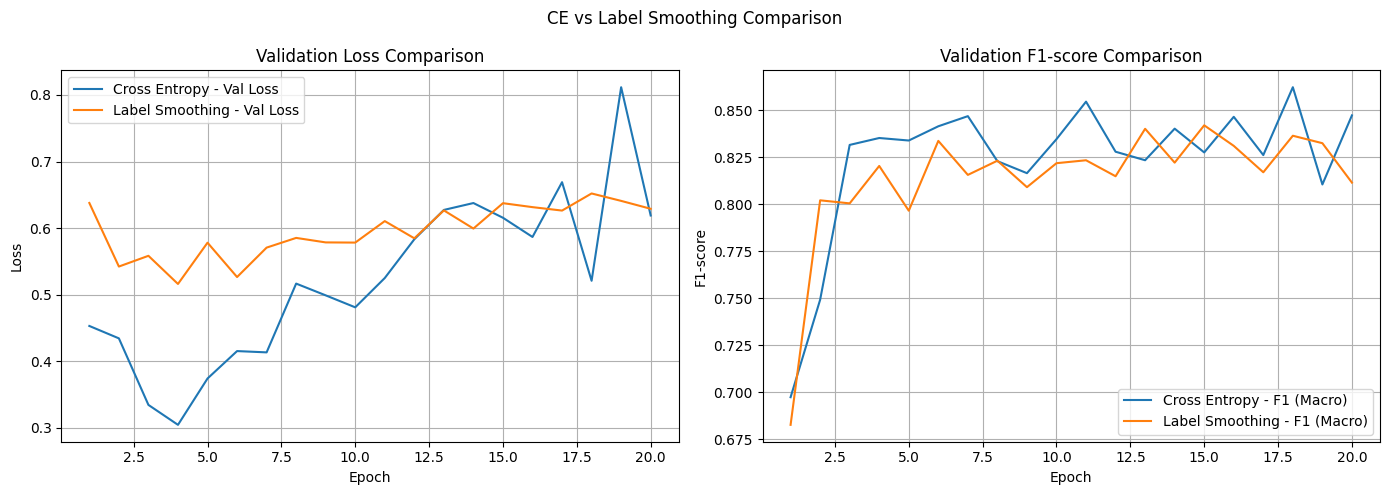

In [43]:
plot_experiment_comparison(
    trainer_ce,
    trainer_ls,
    name_a="Cross Entropy",
    name_b="Label Smoothing",
    title="CE vs Label Smoothing Comparison"
)